In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

from torch.optim import lr_scheduler

batch_size=16
learning_rate=0.02
num_epoch=50

## 1. CIFAR10 train, test dataset 가져오기

In [13]:
#cifar_train=dset.CIFAR10("CIFAR10/",train=True,transform=transforms.ToTensor(),target_transform=None,download=True)

#cifar_train=dset.CIFAR10("CIFAR10/",train=True,
                         #transform=transforms.Compose([
                          #   transforms.Resize(36), #36만큼 키움
                           #  transforms.CenterCrop(32), #32로 자름
                            # transforms.RandomHorizontalFlip(), #horizontal 방향으로 뒤집음
                             #transforms.Lambda(lambda x:x.rotate(90)),
                             #transforms.ToTensor()]))
                         
#cifar_test=dset.CIFAR10("CIFAR10/",train=False,transform=transforms.ToTensor(),target_transform=None,download=True)
cifar_train=dset.CIFAR10("CIFAR10/",train=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)),]),target_transform=None,download=True)
cifar_test=dset.CIFAR10("CIFAR10/",train=False,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5)),]),target_transform=None,download=True)

Files already downloaded and verified
Files already downloaded and verified


## 2. 대략적인 데이터 형태

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cifar_train 길이:  50000
cifar_test 길이:  10000
image data 형태:  torch.Size([3, 32, 32])
label:  9


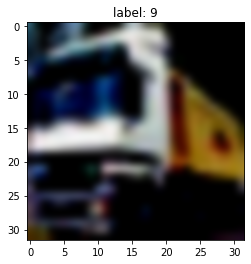

In [3]:
print("cifar_train 길이: ",len(cifar_train)) #50000장
print("cifar_test 길이: ",len(cifar_test))

#데이터 하나 형태
image,label=cifar_train.__getitem__(1) #1번째 데이터
print("image data 형태: ",image.size())
print("label: ",label)

#그리기
img=image.numpy() #image 타입을 numpy로 변환

#(3,32,32)-> (32,32,3)
r,g,b=img[0,:,:],img[1,:,:],img[2,:,:]
#img=img.reshape(img.shape[1],img.shape[2],img.shape[0])
img2=np.zeros((img.shape[1],img.shape[2],img.shape[0]))
img2[:,:,0],img2[:,:,1],img2[:,:,2]=r,g,b

plt.title("label: %d"%label)
plt.imshow(img2,interpolation='bicubic')
plt.show()

In [4]:
def ComputeAccr(dloader,imodel):
    correct=0
    total=0
    for j,[imgs,labels] in enumerate(dloader):
        with torch.no_grad():
            img=Variable(imgs).cuda()
        label=Variable(labels).cuda()
            
        output=imodel.forward(img)
        _,output_index=torch.max(output,1)

        total+=label.size(0) #1024
        correct+=(output_index==label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))

## 3. 데이터 로드함수

In [5]:
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:],batch_size=batch_size,shuffle=True,num_workers=2,drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test,batch_size=batch_size,shuffle=False,num_workers=2,drop_last=True)

## 4. 모델선언

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(3,16,3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            #nn.BatchNorm2d(16),
            nn.Conv2d(16,32,3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            #nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            #nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2)
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*8*8,100),
            nn.ReLU(),
            nn.Dropout2d(0.4),
            #nn.BatchNorm1d(100),
            nn.Linear(100,10)
        )
        
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m,nn.Linear):
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
        
    def forward(self,x):
            out=self.layer(x)
            out=out.view(batch_size,-1)
            out=self.fc_layer(out)
            return out
model=CNN().cuda()

## 5. loss, optimizer

In [7]:
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)
scheduler=lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.2)

## 6. 학습

In [8]:
model.train()
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x=Variable(image).cuda()
        y_=Variable(label).cuda()
        
        optimizer.zero_grad()
        output=model.forward(x)
        loss=loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
        if j%1000==0:
            print(j,loss)

0 tensor(2.3394, device='cuda:0', grad_fn=<NllLossBackward>)
1000 tensor(1.8079, device='cuda:0', grad_fn=<NllLossBackward>)
2000 tensor(2.1178, device='cuda:0', grad_fn=<NllLossBackward>)
3000 tensor(1.4482, device='cuda:0', grad_fn=<NllLossBackward>)
0 tensor(2.0753, device='cuda:0', grad_fn=<NllLossBackward>)
1000 tensor(1.6987, device='cuda:0', grad_fn=<NllLossBackward>)
2000 tensor(1.5720, device='cuda:0', grad_fn=<NllLossBackward>)
3000 tensor(1.6663, device='cuda:0', grad_fn=<NllLossBackward>)
0 tensor(1.2610, device='cuda:0', grad_fn=<NllLossBackward>)
1000 tensor(1.4366, device='cuda:0', grad_fn=<NllLossBackward>)
2000 tensor(1.7557, device='cuda:0', grad_fn=<NllLossBackward>)
3000 tensor(1.4762, device='cuda:0', grad_fn=<NllLossBackward>)
0 tensor(1.5504, device='cuda:0', grad_fn=<NllLossBackward>)
1000 tensor(1.3861, device='cuda:0', grad_fn=<NllLossBackward>)
2000 tensor(1.3243, device='cuda:0', grad_fn=<NllLossBackward>)
3000 tensor(1.0551, device='cuda:0', grad_fn=<NllLos

## (0) Naive Test 

In [ ]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 16.780000686645508


## (1) drop Out

In [ ]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 14.859999656677246


## (2) Data augmentation

In [ ]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 12.6899995803833


## (3) Weight initialization

In [ ]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 45.29999923706055


## (4) Data Normalization

In [ ]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 26.719999313354492


## (5) Batch normaliazation

In [ ]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 61.709999084472656


## (6) Adam optimizer

In [ ]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 58.59000015258789


## (7) learning rate decay

In [ ]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 65.27999877929688




## (8) 내가 만든 코드


In [ ]:
#epoch 50, data 정규화, SGD, learnng rate 0.001, drop out 0.2, weight initialization
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 71.5199966430664


In [ ]:
#epoch 50, data 정규화, SGD, learnng rate 0.001, drop out 0.3, weight initialization
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 62.89999771118164


In [ ]:
#epoch 50, data 정규화, SGD, learnng rate 0.001, drop out 0.25, weight initialization
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 66.69999694824219


In [ ]:
#epoch 50, data 정규화, SGD, learnng rate 0.002, drop out 0.2, weight initialization
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 72.1500015258789


In [ ]:
#epoch 50, data 정규화, SGD, learnng rate 0.002, drop out 0.25, weight initialization
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 69.81999969482422


In [ ]:
#epoch 50, data 정규화, SGD, learnng rate 0.002, 마지막에만 drop out 0.2, weight initialization
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 70.63999938964844


In [ ]:
#epoch 50, data 정규화, SGD, learnng rate 0.002, 마지막에만 drop out 0.25, weight initialization
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 70.62999725341797


In [ ]:
#epoch 50, data 정규화, SGD, learnng rate 0.002, 마지막에만 drop out 0.3, weight initialization
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 71.06999969482422


In [ ]:
#epoch 50, data 정규화, SGD, learnng rate 0.002, 마지막에만 drop out 0.4, weight initialization
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 72.19999694824219


In [ ]:
#epoch 50, data 정규화, SGD, learnng rate 0.01, 마지막에만 drop out 0.4, weight initialization
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 72.87999725341797


In [ ]:
#drop out 0.25, 마지막에는 dropout 0.4 나머지는 같게
model.eval()

ComputeAccr(test_loader,model)

Accuracy of Test Data: 75.38999938964844


아! drop out 비율이 핵심이구나


In [ ]:
# drop out 0.3, 마지막에는 dropout 0.4 나머지는 같게
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 74.18000030517578


In [ ]:
#drop out 0.2, 마지막에는 dropout 0.4 나머지는 같게 , weight initialization 안함
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 74.65999603271484


In [ ]:
#drop out 0.2, 마지막에는 dropout 0.4 나머지는 같게 , weight initialization 하고, learning rate 0.02
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 75.43000030517578


In [ ]:
#drop out 0.25, 마지막에는 dropout 0.4 나머지는 같게 , weight initialization 하고, learning rate 0.03
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 73.36000061035156


In [ ]:
# drop out 0.25, 마지막에는 dropout 0.4 나머지는 같게 , weight initialization 하고, learning rate 0.005
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 73.5199966430664


In [ ]:
#drop out 0.25, 마지막에는 dropout 0.4 나머지는 같게 , weight initialization 하고, learning rate 0.008
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 62.62999725341797


In [ ]:
#drop out 0.25, 마지막에는 dropout 0.4 나머지는 같게 , weight initialization 하고, learning rate 0.1
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 56.94999694824219


In [ ]:
# drop out 0.2, 마지막에는 dropout 0.4 나머지는 같게 , weight initialization 하고, learning rate 0.02, epoch 70
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 74.58000183105469


In [ ]:
#drop out 0.2, 마지막에는 dropout 0.4 나머지는 같게 , weight initialization 하고, learning rate 0.02, epoch 30
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 74.27999877929688


In [ ]:
#drop out 0.2, 마지막에는 dropout 0.4 나머지는 같게 , weight initialization 하고, learning rate 0.02, epoch 50
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 75.16999816894531


In [ ]:
#drop out 0.2, 마지막에는 dropout 0.4 나머지는 같게 , weight initialization 하고, learning rate 0.02, epoch 50 scheduler 25
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 75.0199966430664


In [ ]:
# drop out 0.2, 마지막에는 dropout 0.4 나머지는 같게 , weight initialization 하고, learning rate 0.02, epoch 50 scheduler 30
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 74.50999450683594


In [ ]:
# drop out 0.2, 마지막에는 dropout 0.4 나머지는 같게 , weight initialization 하고, learning rate 0.01
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 74.45999908447266


In [ ]:
#batch, 마지막에는 dropout 0.4 나머지는 같게 , weight initialization 하고, learning rate 0.02, epoch 50
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 75.18000030517578


In [9]:
# dropout 0.2마지막에는 dropout 0.4 나머지는 같게 , weight initialization 안하고, learning rate 0.02, epoch 50
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 74.29999542236328


In [ ]:
# dropout 0.2마지막에는 dropout 0.4 나머지는 같게 , weight initialization 하고, learning rate 0.02, epoch 50
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 76.02999877929688


In [ ]:
netname='mynet01.pkl'
torch.save(model,netname,)

In [12]:
model=torch.load('CIFAR10/mynet01.pkl')
ComputeAccr(test_loader,model)

Accuracy of Test Data: 76.02999877929688
